<a href="https://colab.research.google.com/github/acstevens01/FTGP_3/blob/main/5FNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('stock_data_noTicker.csv')

In [4]:
missing_values = data.isnull().sum()

# 显示存在缺失值的列及其数量
missing_values[missing_values > 0]

Series([], dtype: int64)

In [5]:
from sklearn.preprocessing import MinMaxScaler
# 将日期列转换为datetime对象
data['date'] = pd.to_datetime(data['date'])

# 根据日期进行数据划分
train_data = data[data['date'].dt.year.between(1990, 2015)]
val_data = data[data['date'].dt.year.between(2016, 2019)]
test_data = data[data['date'].dt.year.between(2020, 2022)]

# 提取特征和标签
X_train = train_data.iloc[:, 4:]
y_train = train_data['MthRet']
X_val = val_data.iloc[:, 4:]
y_val = val_data['MthRet']
X_test = test_data.iloc[:, 4:]
y_test = test_data['MthRet']

# 数据归一化
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape



((6365, 50), (1229, 50), (869, 50))

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# 设置随机种子以确保结果的可复现性
torch.manual_seed(42)

# 定义模型结构
class FiveLayerStockPredictor(nn.Module):
    def __init__(self, input_dim):
        super(FiveLayerStockPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        return self.fc5(x)

# 实例化模型、定义损失函数和优化器
model = FiveLayerStockPredictor(X_train_scaled.shape[1])
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# 将数据转换为 PyTorch 张量
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.to_numpy()).view(-1, 1)  # 修改这里
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.FloatTensor(y_val.to_numpy()).view(-1, 1)  # 修改这里

# 训练模型
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 使用验证集评估模型
    model.eval()
    val_outputs = model(X_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}")


Epoch [10/1000], Training Loss: 0.0183, Validation Loss: 0.0148
Epoch [20/1000], Training Loss: 0.0178, Validation Loss: 0.0144
Epoch [30/1000], Training Loss: 0.0173, Validation Loss: 0.0138
Epoch [40/1000], Training Loss: 0.0167, Validation Loss: 0.0133
Epoch [50/1000], Training Loss: 0.0162, Validation Loss: 0.0128
Epoch [60/1000], Training Loss: 0.0156, Validation Loss: 0.0123
Epoch [70/1000], Training Loss: 0.0151, Validation Loss: 0.0118
Epoch [80/1000], Training Loss: 0.0147, Validation Loss: 0.0113
Epoch [90/1000], Training Loss: 0.0142, Validation Loss: 0.0109
Epoch [100/1000], Training Loss: 0.0138, Validation Loss: 0.0105
Epoch [110/1000], Training Loss: 0.0134, Validation Loss: 0.0101
Epoch [120/1000], Training Loss: 0.0130, Validation Loss: 0.0098
Epoch [130/1000], Training Loss: 0.0127, Validation Loss: 0.0094
Epoch [140/1000], Training Loss: 0.0123, Validation Loss: 0.0091
Epoch [150/1000], Training Loss: 0.0120, Validation Loss: 0.0088
Epoch [160/1000], Training Loss: 0

Test Set Metrics:
Explained Variance: -0.0015395872789860654
Mean Squared Error: 0.007179799233135182
R^2 Score: -0.027018004722581868


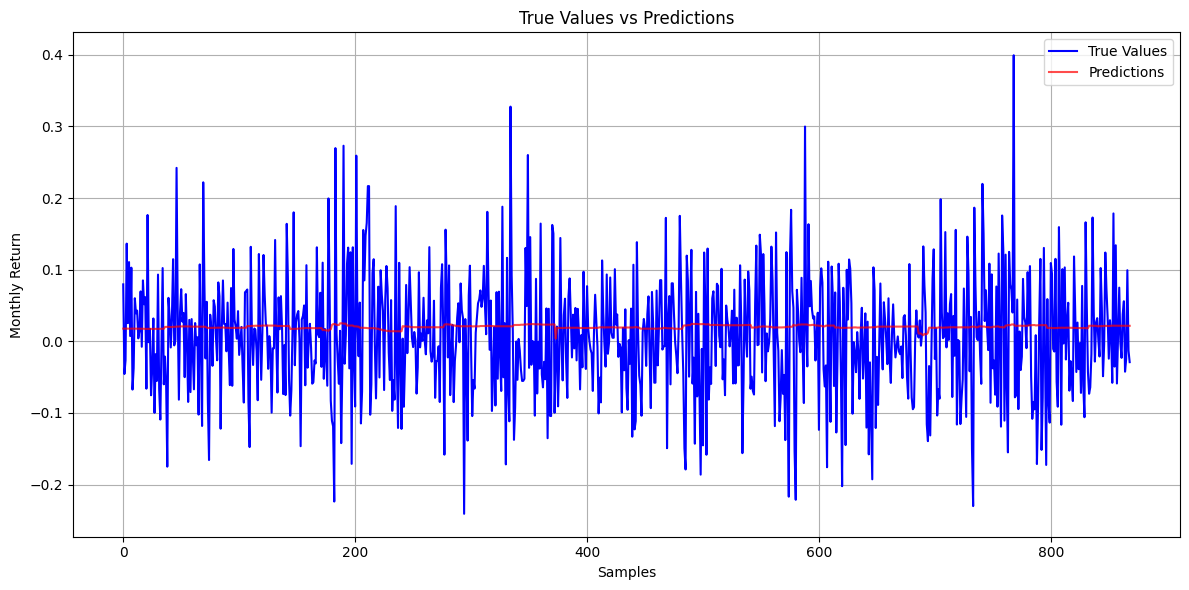

In [7]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 使用模型对测试集进行预测
model.eval()
with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_scaled)
    predictions_test = model(X_test_tensor).numpy()

# 计算测试集上的解释性方差、MSE 和 R^2 分数
explained_variance_test = explained_variance_score(y_test, predictions_test)
mse_test = mean_squared_error(y_test, predictions_test)
r2_test = r2_score(y_test, predictions_test)

print(f"Test Set Metrics:")
print(f"Explained Variance: {explained_variance_test}")
print(f"Mean Squared Error: {mse_test}")
print(f"R^2 Score: {r2_test}")

# 可视化预测结果和真实值
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue')
plt.plot(predictions_test, label='Predictions', color='red', alpha=0.7)
plt.title('True Values vs Predictions')
plt.xlabel('Samples')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

# 定义超参数空间
learning_rates = [0.0001, 0.001, 0.01, 0.1]
optimizers = ['SGD']
#optimizers = ['SGD', 'Adam']
batch_sizes = [8, 16, 32]
epochs_list = [50, 100, 200, 400]

best_val_loss = float('inf')
best_params = {}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for lr in learning_rates:
    for opt in optimizers:
        for batch_size in batch_sizes:
            for num_epochs in epochs_list:
                avg_val_loss = 0.0

                for train_index, val_index in kf.split(X_train_scaled):
                    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
                    y_train_fold, y_val_fold = y_train.to_numpy()[train_index], y_train.to_numpy()[val_index]

                    # Convert data to tensors
                    train_dataset = TensorDataset(torch.FloatTensor(X_train_fold), torch.FloatTensor(y_train_fold).view(-1, 1))
                    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                    X_val_tensor_fold = torch.FloatTensor(X_val_fold)
                    y_val_tensor_fold = torch.FloatTensor(y_val_fold).view(-1, 1)

                    model = FiveLayerStockPredictor(X_train_fold.shape[1])
                    criterion = nn.MSELoss()

                    if opt == 'SGD':
                        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
                    elif opt == 'Adam':
                        optimizer = optim.Adam(model.parameters(), lr=lr)

                    # Train model
                    for epoch in range(num_epochs):
                        model.train()
                        for batch_X, batch_y in train_loader:
                            outputs = model(batch_X)
                            loss = criterion(outputs, batch_y)
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                    # Calculate validation loss
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor_fold)
                        val_loss = criterion(val_outputs, y_val_tensor_fold)

                    avg_val_loss += val_loss.item() / 5

                # Update best parameters
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_params = {'learning_rate': lr, 'optimizer': opt, 'batch_size': batch_size, 'epochs': num_epochs}

print(f"Best Parameters: {best_params}, with validation loss: {best_val_loss:.4f}")


Best Parameters: {'learning_rate': 0.01, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 400}, with validation loss: 0.0058


In [10]:
print(f"Best Parameters: {best_params}, with validation loss: {best_val_loss:.4f}")

Best Parameters: {'learning_rate': 0.01, 'optimizer': 'SGD', 'batch_size': 32, 'epochs': 400}, with validation loss: 0.0058


In [11]:
# 使用最佳参数设置模型
model = FiveLayerStockPredictor(X_train_scaled.shape[1])
criterion = nn.MSELoss()

if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['learning_rate'], momentum=0.9)
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])

# 使用整个训练集训练模型
train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train.to_numpy()).view(-1, 1))
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)

for epoch in range(best_params['epochs']):
    model.train()
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# 在测试集上评估模型
model.eval()
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.to_numpy()).view(-1, 1)

with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)

print(f"Test Loss: {test_loss.item():.4f}")


Test Loss: 0.0066


In [12]:
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score

# 使用模型在测试集上进行预测
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)

# 将预测转换为NumPy数组
predicted = test_outputs.numpy().flatten()
true_values = y_test.to_numpy()

# 计算评估指标
mse = mean_squared_error(true_values, predicted)
explained_var = explained_variance_score(true_values, predicted)
r2 = r2_score(true_values, predicted)

print(f"MSE: {mse:.4f}")
print(f"Explained Variance: {explained_var:.4f}")
print(f"R^2 Score: {r2:.4f}")


MSE: 0.0066
Explained Variance: 0.0923
R^2 Score: 0.0604


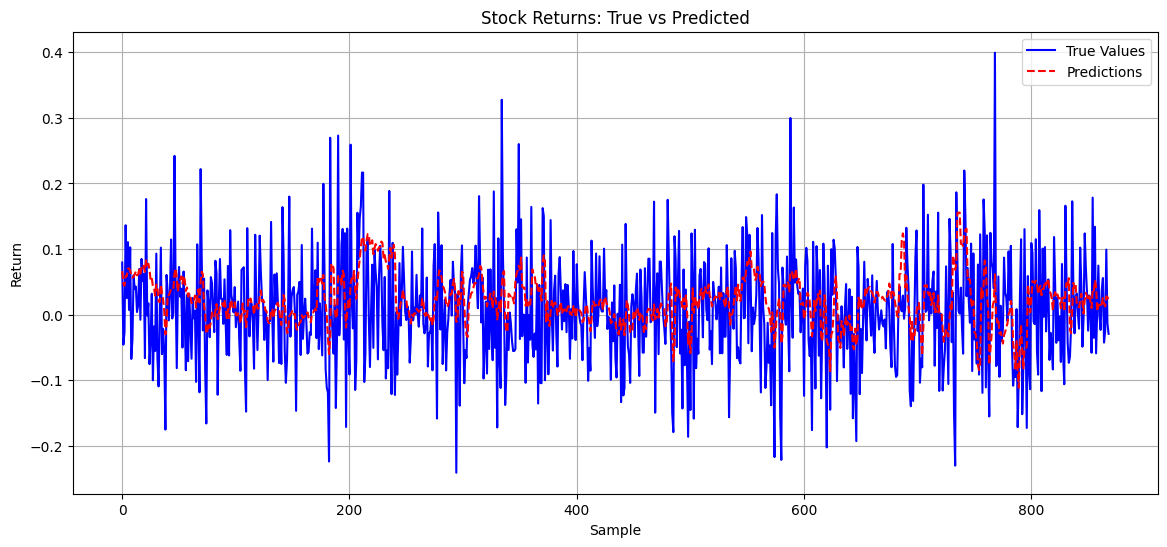

In [13]:
import matplotlib.pyplot as plt

# 获取预测结果
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).numpy().flatten()

# 绘制真实值和预测值
plt.figure(figsize=(14, 6))
plt.plot(true_values, label='True Values', color='blue')
plt.plot(predictions, label='Predictions', color='red', linestyle='dashed')
plt.legend()
plt.title('Stock Returns: True vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Return')
plt.grid(True)
plt.show()
